# Приоритизация гипотез и анализ результатов A/B теста

В наличии имеется подготовленный список гипотез для увеличения выручки.

**Цель проекта:**

Приоритизировать гипотезы, запустить A/B-тест и проанализирвать результаты.


##  Изучение и подготовка общей информации. 

Импортируем данные. Изучим общую информацию в таблицах и проверим корректность данных.

In [1]:
!pip install plotly -U
!pip install statsmodels -U

  Using cached statsmodels-0.13.2-cp38-cp38-win_amd64.whl (9.1 MB)
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'c:\\programdata\\anaconda3\\lib\\site-packages\\patsy\\build.py'
Consider using the `--user` option or check the permissions.



In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings
import datetime
warnings.filterwarnings('ignore')
import seaborn as sns
import pylab
import plotly.graph_objects as go
import plotly.express  as  px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib.dates as mdates

init_notebook_mode(connected=True)
pd.set_option('display.max_colwidth', -1)

In [3]:
# откроем файлы с данными используя конструкцию try-except
server_path = '/datasets/hypothesis.csv'
filename = 'hypothesis.csv'
try:
    hypothesis = pd.read_csv(server_path)
except:
    hypothesis = pd.read_csv(filename)
    
server_path = '/datasets/orders.csv'
filename = 'orders.csv'
try:
    orders = pd.read_csv(server_path)
except:
    orders = pd.read_csv(filename)
    
server_path = '/datasets/visitors.csv'
filename = 'visitors.csv'
try:
    visitors = pd.read_csv(server_path)
except:
    visitors = pd.read_csv(filename)

In [4]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Таблица **hypothesis** содержит 5 столбцов с информацией:

**Hypothesis** — краткое описание гипотезы (тип object)

**Reach** — охват пользователей по 10-балльной шкале (тип int64)

**Impact** - влияние на пользователей по 10-балльной шкале (тип int64)

**Confidence** — уверенность в гипотезе по 10-балльной шкале (тип object)

**Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале (тип uint64)

Пропущенных данных в таблице нет. Во всех названиях столбцов содержатся буквы разного регистра, что может создать некоторые неудобства при дальнейшей обработке. 


In [6]:
# приведем все названия к нижнему регистру, используя метод lower().
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [7]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Таблица **orders** содержит пять столбцов с информацией:

**transactionId** — идентификатор заказа (тип int64)

**visitorId** — идентификатор пользователя, совершившего заказ (тип int64)

**date** - дата, когда был совершён заказ (тип object)

**revenue** — выручка заказа (тип int64)

**group** — группа A/B-теста, в которую попал заказ (тип object)

Пропущенных данных в таблице нет. В столбце **date** содержтся данные о дате и времени, а тип данных object.  


In [9]:
orders['date'] = pd.to_datetime(orders['date'])

In [10]:
# Изменим названия столбцов для удобства
orders.rename(columns = lambda x: x.replace('transactionId','transaction_id'), inplace=True)
orders.rename(columns = lambda x: x.replace('visitorId','visitor_id'), inplace=True)

In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Таблица **visitors** содержит три столбца с информацией:

**date** — дата (тип object)

**group** - группа A/B-теста (тип object)

**visitors** — количество пользователей в указанную дату в указанной группе A/B-теста (тип int64)

Пропущенных данных в таблице нет. В столбце **date** содержтся данные о дате и времени, а тип данных object. Во всех названиях столбцов содержатся буквы одинакового регистра, замену регистра производить не нужно.

In [13]:
visitors['date'] = pd.to_datetime(visitors['date'])

Проведем проверку данных на наличие дубликатов, используя метод duplicated()

In [14]:
print('Количество дубликатов в таблице hypothesis:', hypothesis.duplicated().sum())
print('Количество дубликатов в таблице orders:', orders.duplicated().sum())
print('Количество дубликатов в таблице visitors:', visitors.duplicated().sum())

Количество дубликатов в таблице hypothesis: 0
Количество дубликатов в таблице orders: 0
Количество дубликатов в таблице visitors: 0


Проверим, есть ли у нас пользователи, которые попали в две группы А/В-теста одновременно.

In [15]:
user_A = orders.query('group == "A"')['visitor_id'].unique()
user_B = orders.query('group == "B"')['visitor_id'].unique()

user_A_B = set(user_A).intersection(set(user_B))
print('Количество уникальных пользователей, попавших в две группы:', len(user_A_B))
#user_A_B


Количество уникальных пользователей, попавших в две группы: 58


Сформируем таблицу пользователей, попавших в две группы одновременно.

In [16]:
A_B_count = orders.query('visitor_id in @user_A_B')
A_B_count.head()


,transaction_id,visitor_id,date,revenue,group
2,2961555356,4069496402,2019-08-15,400,A
20,2904772834,963407295,2019-08-15,300,B
23,4252514150,351125977,2019-08-15,15185,B
24,1162046357,3234906277,2019-08-15,7555,B
26,2223239646,199603092,2019-08-15,3488,A


Посмотрим, сколько сессий у каждого из таких пользователей

In [17]:
grouped_A_B_count = A_B_count.groupby(['visitor_id', 'group'])
transaction_id_count = grouped_A_B_count.agg({'transaction_id': pd.Series.count, 'revenue': pd.Series.sum})
transaction_id_count.head(10)

transaction_id  revenue
visitor_id group                         
8300375    A      1               1790   
           B      1               10510  
199603092  A      4               19692  
           B      1               3488   
232979603  A      1               60     
           B      1               2640   
237748145  A      4               3190   
           B      1               7620   
276558944  A      1               5050   
           B      1               12350

Есть пользователи, у которых по одной сессии в каждой группе, т.е. всего две сессии, также есть пользователи, у которых более двух сессий.

Так как в рамках этого A/B теста не пользователей, а сесии разделяли на группы, то проблемы в том, что пользователь попал в обе группы, нет. Просто так вышло, что он совершил несколько сессий, которые определились в разные группы.

### Вывод

Предоставленные таблицы содержат 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort и полученные результаты A/B-теста. Все таблицы корректно загружены, пропусков не обнаружено. Преобразованы названия полей, а также приведены типы данных, проведена проверка на наличие дубликатов - дубликатов нет. Выявлены пользователи, попавшие в две группы  А\В-теста. Их оказалось 58.

## Приоритизация гипотез.

**Применим фреймворк ICE для приоритизации гипотез, отсортируем их по убыванию приоритета.**

In [18]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis_ICE = hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2)
hypothesis_ICE

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


В соответствии с фреймворком **ICE** для приоритизации гипотез, наиболее перспективными являются гипотезы:

1) Запустить акцию, дающую скидку на товар в день рождения

2) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

3) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

**Применим фреймворк RICE  для приоритизации гипотез, отсортируем их по убыванию приоритета.**

In [19]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis_RICE = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
hypothesis_RICE

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


В соответствии с фреймворком **RICE** для приоритизации гипотез, наиболее перспективными являются гипотезы:

**1)** Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

**2)** Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

**3)** Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей



**Посмотрим, как изменилась приоритизация гипотез при применении RICE вместо ICE.**

In [20]:
priority_of_hypothesis = hypothesis_ICE.merge(hypothesis_RICE, on='hypothesis')
priority_of_hypothesis

,hypothesis,ICE,RICE
0,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


Фреймворк **RICE** включает в себя дополнительный компонент **Reach** — скольких пользователей затронет изменение, которое мы хотим внести. Поэтому дополнение этого компонента изменило практически всю приоритетность, полученную по методу **ICE**, только две гипотезы остались на прежних местах. 

На четвертом месте в обоих случаях была гипотеза:

**Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию**

На последнем, девятом месте в обоих случаях была гипотеза:
    
**Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей**


### Вывод

Анализ показывает, что при применении фреймворка **ICE** и фреймворка **RICE** наиболее перспективными являютя гипотезы:

-Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

-Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Самой бесперспективной оказалась гипотеза:

-Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей

## Анализ A/B-теста

**Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.**

In [21]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# Получим строки orders, дата которых <= дате элемента из datesGroups, а группа теста равна группе из datesGroups
# Агрегируем значения, найдём число уникальных ID заказов и пользователей
# Подсчитаем сумму средних чеков

ordersAggregated = (datesGroups.apply(lambda x: 
orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == 
x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique,
'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']))

# Получим нужные строки visitors, агрегируем значения
# Посчитаем количество пользователей

visitorsAggregated = (datesGroups.apply(lambda x: 
visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == 
x['group'])].agg({'date' : 'max', 'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']))

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 
'group'], right_on=['date', 'group'])
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cummulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01  A     24      20      148579   719     
1 2019-08-01  B     21      20      101217   713     
2 2019-08-02  A     44      38      242401   1338    
3 2019-08-02  B     45      43      266748   1294    
4 2019-08-03  A     68      62      354874   1845    


Построим график

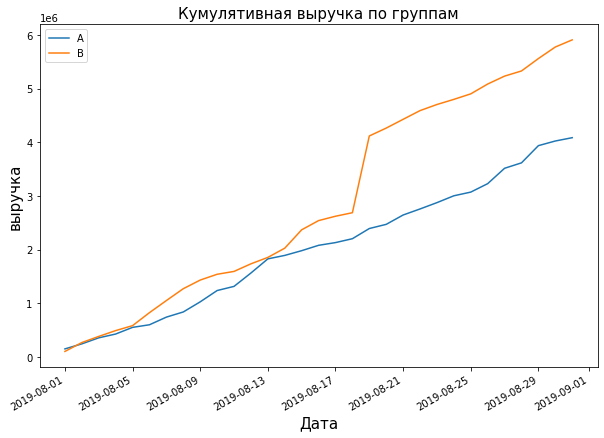

In [22]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А и B
cummulativeRevenueA = cummulativeData[cummulativeData['group']=='A'][['date','revenue', 'orders']]
cummulativeRevenueB = cummulativeData[cummulativeData['group']=='B'][['date','revenue', 'orders']]


cummulativeRevenueA['date'] = pd.to_datetime(cummulativeRevenueA['date'], format='%Y-%m-%d')
cummulativeRevenueB['date'] = pd.to_datetime(cummulativeRevenueB['date'], format='%Y-%m-%d')


# Строим график выручки группы А и B

fig = plt.figure(figsize=[10,7])
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'], label='B')
fig.autofmt_xdate()
plt.title('Кумулятивная выручка по группам', fontsize=15);
plt.xlabel('Дата', fontsize= 15)
plt.ylabel('выручка', fontsize= 15) 
plt.legend()
plt.show()


Выручка увеличивается в течение всего теста, но график выручки группы B в одной точке резко растет. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке.

**Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.**

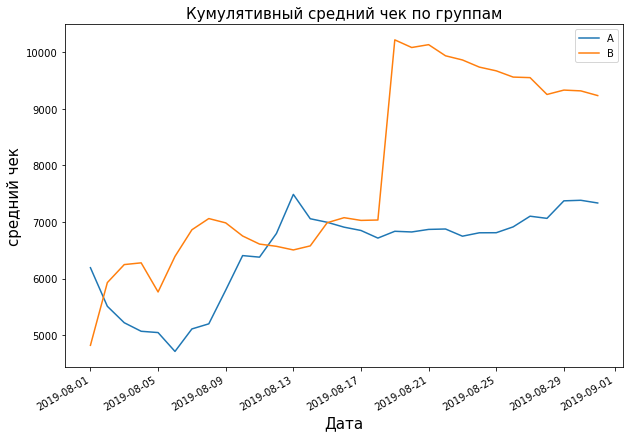

In [23]:
fig = plt.figure(figsize=[10,7])
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue']/cummulativeRevenueA['orders'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue']/cummulativeRevenueB['orders'], label='B')
fig.autofmt_xdate()
plt.title('Кумулятивный средний чек по группам', fontsize=15);
plt.xlabel('Дата', fontsize= 15)
plt.ylabel('средний чек', fontsize= 15) 
plt.legend()
plt.show()

Средний чек становится более равномерным к концу теста: немного растет для группы A и и продолжает падать для группы B. Возможно, в группу B в середине теста попали крупные заказы (резкий всплеск на графике).

**Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.**

При построении графика относительного различия для среднего чека добавим горизонтальную ось методом axhline().

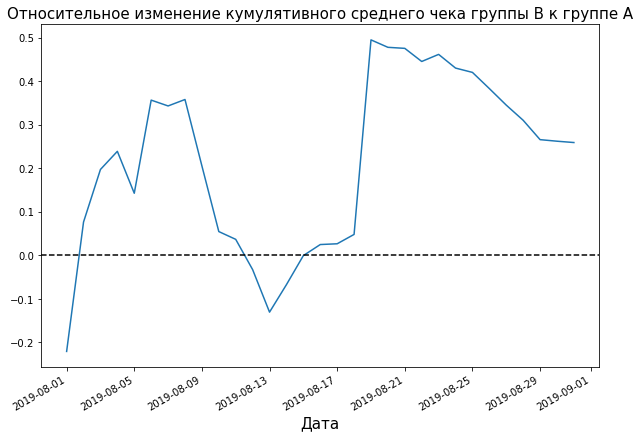

In [24]:
fig = plt.figure(figsize=[10,7])
# собираем данные в одном датафрейме
mergedCummulativeRevenue = cummulativeRevenueA.merge(cummulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCummulativeRevenue['date'], (mergedCummulativeRevenue['revenueB']/mergedCummulativeRevenue['ordersB'])/(mergedCummulativeRevenue['revenueA']/mergedCummulativeRevenue['ordersA'])-1,)
fig.autofmt_xdate()
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
#plt.axis(['2019-08-01', '2019-08-31', -0.4, 0.6])
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A', fontsize=15);
plt.xlabel('Дата', fontsize= 15)
plt.show()

График различия между сегментами резко «скачет». Сначала средний чек группы B стабильно растет, потом резко падает и резко взлетает. Возможно это влияние крупных заказов и выбросов. Все три графика демонстрируют одинаковую картину.

**Построим график кумулятивной конверсии по группам. Сделаем выводы и предположения.**

Проведем анализ графика кумулятивной конверсии, для осей масштаб зададим методом plt.axis().

In [25]:
# считаем кумулятивную конверсию
cummulativeData['conversion'] = cummulativeData['orders']/cummulativeData['visitors']
print('минимальная кумулятивная конверсия равна:', cummulativeData['conversion'].min())
print('максимальная кумулятивная конверсия равна:', cummulativeData['conversion'].max())

минимальная кумулятивная конверсия равна: 0.029217427214536445
максимальная кумулятивная конверсия равна: 0.03685636856368564


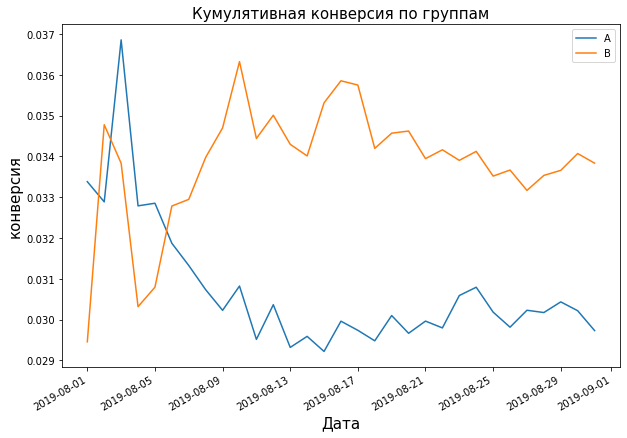

In [26]:
cummulativeData['date'] = pd.to_datetime(cummulativeData['date'], format='%Y-%m-%d')

# отделяем данные по группе A и B
cummulativeDataA = cummulativeData[cummulativeData['group']=='A']
cummulativeDataB = cummulativeData[cummulativeData['group']=='B']


# строим графики
fig = plt.figure(figsize=[10,7])
plt.plot(cummulativeDataA['date'], cummulativeDataA['conversion'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['conversion'], label='B')
fig.autofmt_xdate()
plt.legend()
plt.title('Кумулятивная конверсия по группам', fontsize=15);
plt.xlabel('Дата', fontsize= 15)
plt.ylabel('конверсия', fontsize= 15) 

# задаем масштаб осей
#plt.axis(["2019-08-01", '2019-08-31', 0.025, 0.040])
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.axis(['2019-08-01', '2019-08-31', 0.025, 0.040])
plt.show()

Группы колебались около одного значения, но затем конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы A просела и также зафиксировалась.

**Построим график относительного изменения кумулятивной конверсии группы B к группе A. Сделаем выводы и предположения.**

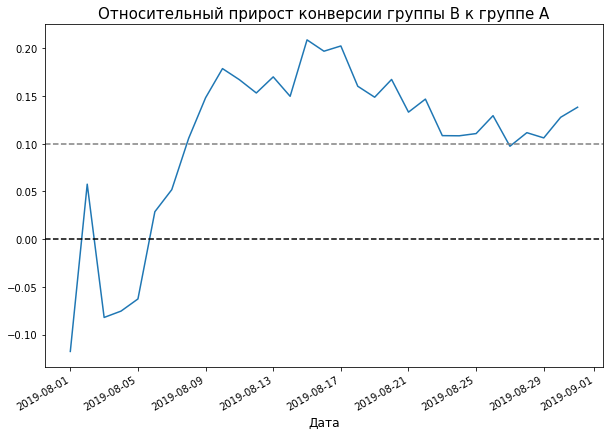

In [27]:
mergedCummulativeConversions = cummulativeDataA[['date','conversion']].merge(
    cummulativeDataB[['date','conversion']], 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)


fig = plt.figure(figsize=[10,7])
plt.plot(
    mergedCummulativeConversions['date'], 
    mergedCummulativeConversions['conversionB']/mergedCummulativeConversions['conversionA']-1
)

plt.title('Относительный прирост конверсии группы B к группе A', fontsize=15);
plt.xlabel('Дата', fontsize= 12)

fig.autofmt_xdate()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
#plt.axis(["2019-08-01", '2019-08-31', -0.2, 0.3])

plt.show()

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Конверсия группы B стабильно выше. Стоит проанализировать аномалии, возможно результаты изменятся.

**Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.**

In [28]:
# Подсчитаем количество заказов по пользователям:
ordersByUsers = orders.drop(
    ['group', 'revenue', 'date'], 
    axis=1
).groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})

ordersByUsers.columns = ['visitor_id','orders']

print(ordersByUsers.sort_values(by='orders',ascending=False).head(10))

      visitor_id  orders
1023  4256040402  11    
591   2458001652  11    
569   2378935119  9     
487   2038680547  8     
44    199603092   5     
744   3062433592  5     
55    237748145   5     
917   3803269165  5     
299   1230306981  5     
897   3717692402  5     


Построим гистограмму распределения количества заказов на одного пользователя.

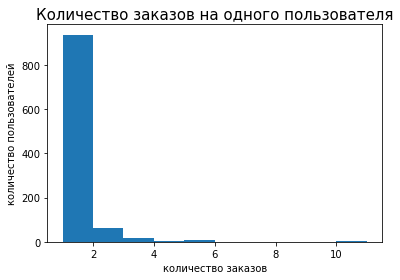

In [29]:
plt.hist(ordersByUsers['orders'])
plt.title('Количество заказов на одного пользователя', fontsize=15);
plt.xlabel('количество заказов', fontsize= 10)
plt.ylabel('количество пользователей', fontsize= 10) 
plt.show()


В основном пользватели делают 1 заказ, однако доля пользователей с 2-4 заказами тоже значительна. Есть выбросы где пользователи делают более 10 заказов.

Построим точечную диаграмму числа заказов на одного пользователя:

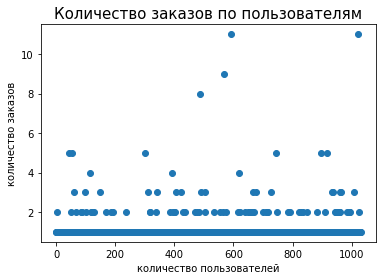

In [30]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Количество заказов по пользователям', fontsize=15);
plt.xlabel('количество пользователей', fontsize= 10)
plt.ylabel('количество заказов', fontsize= 10) 
plt.show()

Выводы подтверждаются: есть пользователи с 2-4 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет. Для принятия решения, посчитаем выборочные перцентили количества заказов на одного пользователя.

**Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.**

In [31]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа.

Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

**Построим точечный график стоимостей заказов. Сделаем выводы и предположения.**

In [32]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

Три четверти стоимостей заказов находятся в пределах 8500. Построим гистограмму распределения стоимостей заказов на одного пользователя.

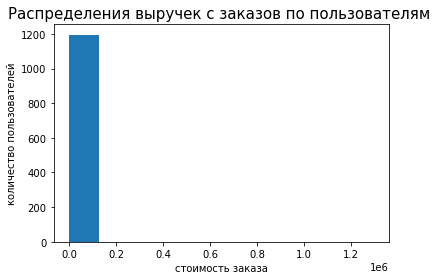

In [33]:
plt.hist(orders['revenue'])
plt.title('Распределения выручек с заказов по пользователям ', fontsize=15);
plt.xlabel('стоимость заказа', fontsize= 10)
plt.ylabel('количество пользователей', fontsize= 10) 
plt.show()

Практически все заказы не превышают стоимость 60000. Построим точечную диаграмму стоимостей заказов для того, чтобы увидеть выбросы.

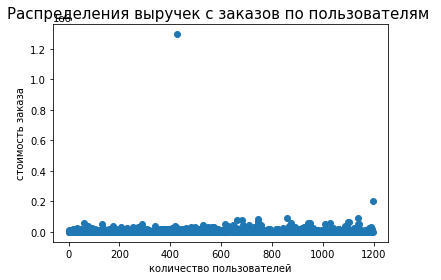

In [34]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue']);
plt.title('Распределения выручек с заказов по пользователям ', fontsize=15);
plt.xlabel('количество пользователей', fontsize= 10)
plt.ylabel('стоимость заказа', fontsize= 10) 
plt.show()

Большая часть заказов со стоимостью до 60000, но есть выбросы со стоимостями в 200000 и  более миллиона. Скорее всего их можно считать аномалиями. Для принятия решения, посчитаем выборочные перцентили стоимости заказов.

**Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.**

In [35]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Менее 5% заказов стоят дороже 28000, можно взять эту цифру за границу для определения аномальных заказов

**Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Сделаем выводы и предположения.**

***Проверим гипотезу1: статистически значимые различия в конверсии между группами есть.***

Сформулируем нулевую и альтернативную гипотезы.

**Нулевая гипотеза:** конверсии в группах А и В по "сырым" данным не отличаются.

**Альтернативная гипотеза:** конверсии в группах А и В по "сырым" данным отличаются.

Уровень значимости возьмем равный 5%.

Для проверки гипотезы подготовим данные.

In [36]:
# Считаем количество пользователей до выбранной даты включительно в группах A и B;

visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
                                            .agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), 
    axis=1
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                                            .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), 
    axis=1
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# Считаем суммарное число заказов до выбранной даты включительно в группах A и B
ordersADaily = orders[orders['group']=='A'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']


# Получаем таблицу с количеством заказов, выручкой в день, 
# количество заказов и выручка до выбранной даты(включительно),
# количество пользователей до выбранной даты 
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [37]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

ordersByUsersA = (
    orders[orders['group']=='A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id' : pd.Series.nunique})
)
    
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group']=='B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id' : pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Подготовим выборки к проверке критерием Манна-Уитни. Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [38]:
sampleA = pd.concat(
    [ordersByUsersA['orders'],pd.Series(
        0, 
        index=np.arange(
            data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
        ), 
        name='orders'
    )
    ],
    axis=0
)
sampleB = pd.concat(
    [ordersByUsersB['orders'],pd.Series(
        0, 
        index=np.arange(
            data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
        ), 
        name='orders'
    )
    ],
    axis=0
)

Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.

In [39]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

#print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

#print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

In [40]:
alpha =0.05
p_value_conv = stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1].round(3)

print('P-value по конверсии для "сырых" данных: {}'.format(p_value_conv))
if (p_value_conv < alpha):
    print("на 5% уровне значимости нулевая гипотеза отвергается")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

print('относительный прирост конверсии группы B по "сырым" данным составляет: {0:.3f}'.format(sampleB.mean()/sampleA.mean()-1))

P-value по конверсии для "сырых" данных: 0.017
на 5% уровне значимости нулевая гипотеза отвергается
относительный прирост конверсии группы B по "сырым" данным составляет: 0.138


По «сырым» данным есть различия в конверсии групп A и B. Относительная разница в конверсиях около 14% (прирост группы B)

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.**

***Гипотеза2: значение среднего чека в группах А и В по "сырым" данным отличается***

Сформулируем нулевую и альтернативную гипотезы.

**Нулевая гипотеза:** различий в среднем чеке в группах А и В по "сырым" данным нет.

**Альтернативная гипотеза:** различия в среднем чеке в группах А и В по "сырым" данным есть.

Уровень значимости возьмем равный 5%.

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, передадим критерию mannwhitneyu() данные о выручке с заказов и найдём относительные различия в среднем чеке между группами:

In [41]:
alpha =0.05
p_value_check = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                   orders[orders['group']=='B']['revenue'], 
                                   alternative = 'two-sided')[1].round(3)

print('P-value по конверсии для "сырых" данных: {}'.format(p_value_check))
if (p_value_check < alpha):
    print("на 5% уровне значимости нулевая гипотеза отвергается")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

print('относительный прирост среднего чека группы B по "сырым" данным составляет: {0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))






P-value по конверсии для "сырых" данных: 0.729
Не получилось отвергнуть нулевую гипотезу
относительный прирост среднего чека группы B по "сырым" данным составляет: 0.259


Средний чек группы B почти на 26% выше среднего чека группы A, скорее всего это из-за аномальных данных.

**Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделаем выводы и предположения.**

За аномальных пользователей были приняты те, кто совершил более двух заказов или совершил заказ дороже 28000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и с дорогими заказами.

Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 28000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers. Узнаем, сколько всего аномальных пользователей методом shape()

In [42]:
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], 
     ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], 
    axis = 0
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = pd.concat(
    [usersWithManyOrders, usersWithExpensiveOrders], 
    axis = 0
).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print("Всего аномальных пользователей: {}".format(abnormalUsers.shape))

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
Всего аномальных пользователей: (74,)


Всего 74 аномальных пользователя. Узнаем, как их действия повлияли на результаты теста. 

**Гипотеза3**: конверсии в группах А и В по "очищенным" данным отличаются.

Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: конверсии в группах А и В по "очищенным" данным не отличаются.

Альтернативная гипотеза: конверсии в группах А и В по "очищенным" данным отличаются.

Уровень значимости возьмем равный 5%.

Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [43]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0, 
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders'
        )
    ],
    axis=0
)
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0, 
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),name='orders'
        )
    ],
    axis=0
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [44]:
#print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
#print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

In [45]:
alpha =0.05
p_value_conv_clean = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1].round(3)

print('P-value по конверсии для "очищенных" данных: {}'.format(p_value_conv_clean))
if (p_value_conv_clean < alpha):
    print("на 5% уровне значимости нулевая гипотеза отвергается")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

print('относительный прирост конверсии группы B по "очищенным" данным составляет: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value по конверсии для "очищенных" данных: 0.013
на 5% уровне значимости нулевая гипотеза отвергается
относительный прирост конверсии группы B по "очищенным" данным составляет: 0.173


По очищенным данным есть статистически значимые различия в конверсии групп A и B. Относительный прирост конверсии группы B составлет 17,3%

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.**

**Гипотеза4**: значение среднего чека в группах А и В по "очищенным" данным отличается

Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: различий в среднем чеке в группах А и В по "очищенным" данным нет.

Альтернативная гипотеза: различия в среднем чеке в группах А и В по "очищенным" данным есть.

Уровень значимости возьмем равный 5%.

In [46]:
alpha =0.05
p_value_check_clean = stats.mannwhitneyu(orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'], 
                                   alternative = 'two-sided')[1].round(3)

print('P-value по конверсии для "очищенных" данных: {}'.format(p_value_check_clean))
if (p_value_check_clean < alpha):
    print("на 5% уровне значимости нулевая гипотеза отвергается")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

print('относительный прирост среднего чека группы B по "очищенным" данным составляет: {0:.3f}'.format(
    orders[np.logical_and(
        orders['group']=='B',
            np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()-1))




P-value по конверсии для "очищенных" данных: 0.738
Не получилось отвергнуть нулевую гипотезу
относительный прирост среднего чека группы B по "очищенным" данным составляет: -0.020


P-value практически не изменился, а разница между сегментами сильно изменилась. Очищенные данные показывают, что средний чек группы B немного уступает группе A, в то время как на сырых данных чек группы B был на 26% больше.

По очищенным данным статистически значимых различий среднего чека между группами нет.

Хотя статистической зачимости и нет, стоит отметить, что разница из положительной стала отрицательной - это дополнительно показывает вклад аномалии.

## Результаты A/B теста

Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.

Как по сырым, так и по очищенным данным нет статистически значимого различия по среднему чеку между группами.

График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту и практически зафиксировались.

График различия среднего чека колеблется. Сделать из этого графика определённые выводы нельзя.

## Решение

Тест можно остановить и считать успешно пройденным. Фиксируем победу группы B. 

Такое решение мы принимаем, потому что анализ показывает наличие статистически значимого различия по конверсии между группами, относительный прирост конверсии группы В составил 17,3%,  хотя конверсия по среднему чеку не имеет значимых различий между группами.

## Общий вывод.

В проекте проанализированы таблицы, содержащие 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort и полученные результаты A/B-теста. Все таблицы корректно загружены, пропусков не обнаружено. Преобразованы названия полей, а также приведены типы данных, проведена проверка на наличие дубликатов,  дубликатов не обнаружено. Выявлены пользователи, попавшие в две группы  А\В-теста. Их оказалось 58. На результаты А/В-теста они, на мой взгляд, не повлияли потому, что в рамках этого A/B теста не пользователей, а сесии разделяли на группы.

В процессе приоритизации 9 гипотез по увеличению выручки интернет-магазина было выявлено, что 
при применении фреймворка ICE и фреймворка RICE наиболее перспективными являютя гипотезы:

-Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

-Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей


Самой бесперспективной оказалась гипотеза:

-Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей

Также проведен анализ результатов А\В теста, который показал, что чаще всего пользователи заказывают 1-2 раза, суммы заказов не более 28000. Поэтому пользователи, у которых более 2 сессий или заказ дороже 28000 были отнесены к "аномальным". Таких оказалось 74.


Проведена проверка гипотез о наличии различий в конверсии между группами А и В как по сырым данным, так и после фильтрации аномалий. Гипотезы подтвердились. Относительный прирост конверсии группы B по "сырым" данным составил 13,8%, а по "очищенным" - 17,3%.

Выдвинутые гипотезы о различии среднего чека по группам не подтвердились, как для "сырых", так идля "очищенных" данных А/В-теста.
Из-за аномальных покупателей средний чек группы B почти на 26% был выше среднего чека группы А.

Построен график различия конверсии между группами. Очевидно, что результаты группы B лучше группы A: имеют тенденцию к росту и практически зафиксировались.

График различия среднего чека колеблется. Сделать из этого графика определённые выводы нельзя.

В результате проведенного А\В- теста побеждает группа В. Тест можно остановить и считать успешно пройденным.